In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [ ]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.12.0


Seeding

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

In [ ]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 8
LR = 1e-4

PATH = "/content/drive/MyDrive/Training_semantic_segmentation/"

Reading the images and masks

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

Building the tf.data pipeline for training, validation and testing dataset.

## Metrics

In [ ]:
  smooth = 1e-15
  def dice_coef(y_true, y_pred):
      y_true = tf.keras.layers.Flatten()(y_true)
      y_pred = tf.keras.layers.Flatten()(y_pred)
      intersection = tf.reduce_sum(y_true * y_pred)
      return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

  def dice_loss(y_true, y_pred):
      return 1.0 - dice_coef(y_true, y_pred)

## Training

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/segmentation_model_2-5-22', custom_objects={'dice_coef':dice_coef,'dice_loss':dice_loss})

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [ ]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
images = os.listdir('b')

In [ ]:
images

['Screenshot 2023-07-16 at 5.45.15 PM.png']

1/1 [==============================] - 0s 77ms/step


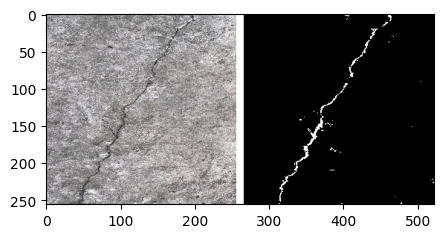

In [ ]:
for x in images: #i, (x, y) in enumerate(zip(test_x[50:100], test_y[50:100])):
    #print(x)
    x = read_image('./b/'+x)
    #y = read_mask(y)
    y_pred = new_model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        #mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    fig = plt.figure(figsize=(5,5))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

Saving the segmented image

In [ ]:
import cv2

for x in images:
    x = read_image('./b/' + x)
    y_pred = new_model.predict(np.expand_dims(x, axis=0))[0] > 0.5

    predicted_image = mask_parse(y_pred)
    predicted_image_uint8 = (predicted_image * 255).astype(np.uint8)

    cv2.imwrite('/content/output1.png', predicted_image_uint8)


1/1 [==============================] - 0s 23ms/step


Applying median filter to output1.png

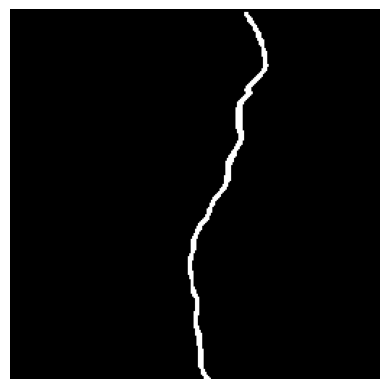

True

In [ ]:
image= cv2.imread('output1.png')
median_blurred_image = cv2.medianBlur(image, ksize=3)  # Change 'ksize' as needed
plt.imshow(median_blurred_image, cmap='gray')
plt.axis('off')  # Remove axes
plt.show()
cv2.imwrite('/content/output_median.png', median_blurred_image)

applying closing operation on the median filtered image

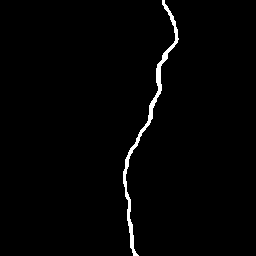

True

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np

# Read the segmented image
segmented_image = median_blurred_image

# Define the kernel for the closing operation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))  # Adjust the kernel size as needed

# Perform closing morphological operation
closed_image = cv2.morphologyEx(segmented_image, cv2.MORPH_CLOSE, kernel)

# Display the closed image
cv2_imshow(closed_image)
cv2.waitKey(0)

# Save the closed image
cv2.imwrite('/content/output_median_closing.png', closed_image)

Calculation of crack length

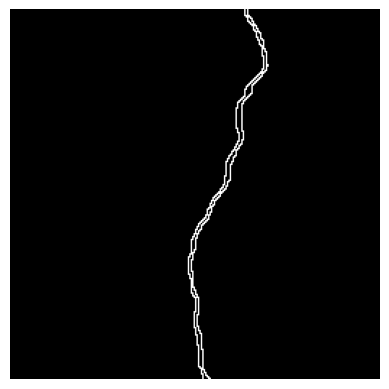

Crack length is: 58.606779296875
Crack pixels are: 338.5


In [ ]:
image = cv2.imread('output_median_closing.png', 0)  # Read the image as grayscale
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))  # Example: 5x5 rectangular kernel
eroded_image = cv2.erode(image, kernel, iterations=1)
eroded_image_inverted = 255 - eroded_image
new_image = cv2.bitwise_and(eroded_image_inverted, image)
plt.imshow(new_image, cmap='gray')
plt.axis('off')  # Remove axes
plt.show()

image_width_pixels = 256
image_height_pixels = 256
image_width_inches = 18.4
image_height_inches = 16.5

horizontal_ppi = image_width_inches/ image_width_pixels
vertical_ppi = image_height_inches/ image_height_pixels

pixels_per_inch = (horizontal_ppi + vertical_ppi)/2

white_pixel_count = cv2.countNonZero(new_image)
white_pixel_count = white_pixel_count/2
crack_length = white_pixel_count*pixels_per_inch*2.54

cv2.imwrite('/content/output_actual_crack_length.png', new_image)

print('Crack length is:', crack_length)
print('Crack pixels are:', white_pixel_count)


trying to draw straight line

[(163, 0), (135, 255)]
Distance between the circles (in cm): 44.41522109910754


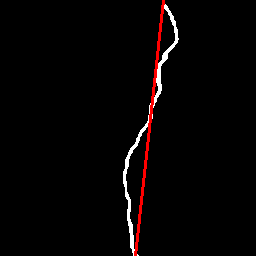

In [ ]:
from scipy.spatial.distance import euclidean

img = cv2.imread('/content/output_median_closing.png')
img2 = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
skeleton = cv2.ximgproc.thinning(th, None, 1)

k1 = np.array(([ 0, 0,  0],
               [-1, 1, -1],
               [-1,-1, -1]), dtype="int")

k2 = np.array(([0, -1, -1],
               [0,  1, -1],
               [0, -1, -1]), dtype="int")

k3 = np.array(([-1, -1, 0],
               [-1,  1, 0],
               [-1, -1, 0]), dtype="int")

k4 = np.array(([-1, -1, -1],
               [-1,  1, -1],
               [ 0,  0,  0]), dtype="int")

o1 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k1)
o2 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k2)
o3 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k3)
o4 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k4)
out1 = o1 + o2 + o3 + o4

k5 = np.array(([-1, -1, -1],
               [-1,  1, -1],
               [ 0, -1, -1]), dtype="int")

k6 = np.array(([-1, -1, -1],
               [-1,  1, -1],
               [-1, -1,  0]), dtype="int")

k7 = np.array(([-1, -1,  0],
               [-1,  1, -1],
               [-1, -1, -1]), dtype="int")

k8 = np.array(([ 0, -1, -1],
               [-1,  1, -1],
               [-1, -1, -1]), dtype="int")

o5 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k5)
o6 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k6)
o7 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k7)
o8 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k8)
out2 = o5 + o6 + o7 + o8


out = cv2.add(out1, out2)
pts = np.argwhere(out == 255)
endpoints = []
for pt in pts:
    # img2 = cv2.circle(img2, (pt[1], pt[0]), 15, (0, 255, 0), -1)
    # print(pt[1], pt[0])
    endpoints.append((pt[1], pt[0]))


# print(endpoints)
tuples_list = endpoints
average_1 = (tuples_list[0][0] + tuples_list[1][0]) // 2
average_2 = (tuples_list[0][1] + tuples_list[1][1]) // 2

# Create the first new tuple with averages
new_tuple1 = (average_1, average_2)

# Calculate the averages for the third and fourth tuples
average_3 = (tuples_list[2][0] + tuples_list[3][0]) // 2
average_4 = (tuples_list[2][1] + tuples_list[3][1]) // 2

# Create the second new tuple with averages
new_tuple2 = (average_3, average_4)

# Final list containing the new tuples
endpoints = [new_tuple1, new_tuple2]

print(endpoints)
img2 = cv2.line(img2, endpoints[0],endpoints[1], (0, 0, 255), thickness=2)

# Calculate the Euclidean distance between the endpoints
distance_pixels = euclidean(endpoints[0], endpoints[1])

image_width_pixels = 256
image_height_pixels = 256
image_width_inches = 16.5
image_height_inches = 18.4

horizontal_ppi = image_width_inches/image_width_pixels
vertical_ppi = image_height_inches/image_height_pixels

pixels_per_inch = (horizontal_ppi + vertical_ppi) / 2

# Convert distance from pixels to inches
distance_cm_straight = distance_pixels*pixels_per_inch*2.54

print("Distance between the circles (in cm):", distance_cm_straight)

cv2.imwrite('/content/output_crack_straight_length.png', img2)

# Display the image with circles
cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

Percentage error

In [ ]:
actual_value = 69.85
absolute_error = abs(distance_cm_straight - actual_value)
percentage_error = (absolute_error / abs(actual_value)) * 100
print(f"The percentage error is: {percentage_error:.2f}%")

The percentage error is: 2.16%


Dice coefficient

In [ ]:
import cv2

def convert_to_grayscale(input_image_path, output_image_path):
    # Load the input image
    input_image = cv2.imread(input_image_path)

    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    # Save the grayscale image
    cv2.imwrite(output_image_path, grayscale_image)

# Replace 'input_image_path' and 'output_image_path' with the actual file paths of the input and output images
input_image_path = '/content/b/Screenshot 2023-07-16 at 8.30.18 PM.png'
output_image_path = '/content/gray_scale.png'

# Call the function to convert the image to grayscale
convert_to_grayscale(input_image_path, output_image_path)


In [ ]:
import cv2

def binarize_image_threshold(input_image_path, output_image_path, threshold_value):
    # Load the input image in grayscale
    input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

    # Apply thresholding
    _, binarized_image = cv2.threshold(input_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Invert the colors of the binarized image
    inverted_image = 255 - binarized_image

    # Save the inverted binarized image
    cv2.imwrite(output_image_path, inverted_image)

# Replace 'input_image_path' and 'output_image_path' with the actual file paths of the input and output images
input_image_path = '/content/gray_scale.png'
output_image_path = '/content/masked.png'

# Set the threshold value (adjust this value based on your image and desired binarization)
threshold_value = 128

# Call the function to binarize the image using thresholding and invert the colors
binarize_image_threshold(input_image_path, output_image_path, threshold_value)


In [ ]:
import cv2
import numpy as np

def remove_noise_from_binary_image(binarized_image_path, output_image_path, kernel_size):
    # Load the binarized image
    binarized_image = cv2.imread(binarized_image_path, cv2.IMREAD_GRAYSCALE)

    # Define the kernel for morphological operations (structuring element)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Perform closing operation to fill small gaps in the foreground (cracks) and remove small background noise
    cleaned_image = cv2.morphologyEx(binarized_image, cv2.MORPH_CLOSE, kernel)

    # Save the cleaned image
    cv2.imwrite(output_image_path, cleaned_image)

# Replace 'binarized_image_path' and 'output_image_path' with the actual file paths of the binarized image and output cleaned image
binarized_image_path = '/content/masked.png'
output_image_path = '/content/masked_denoised.png'

# Set the kernel size for the morphological operations (adjust this value based on the level of noise to be removed)
kernel_size = 11

# Call the function to remove noise from the binarized image
remove_noise_from_binary_image(binarized_image_path, output_image_path, kernel_size)


In [ ]:
import cv2
import numpy as np

def dice_coefficient(original_image_path, segmented_image_path):
    # Load the images
    original_image = cv2.imread(original_image_path)
    segmented_image = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)

    # Ensure the images have the same height
    height, width, _ = original_image.shape
    segmented_image = cv2.resize(segmented_image, (width, height))

    # Convert the images to grayscale
    original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Threshold the images to get binary images
    _, original_binary = cv2.threshold(original_image_gray, 127, 1, cv2.THRESH_BINARY)
    _, segmented_binary = cv2.threshold(segmented_image, 127, 1, cv2.THRESH_BINARY)

    intersection = np.logical_and(original_binary, segmented_binary).sum()
    union = original_binary.sum() + segmented_binary.sum()

    dice = 2 * intersection / union

    return dice

# Replace 'original_image_path' and 'segmented_image_path' with the actual file paths of the images
original_image_path = '/content/masked_denoised.png'
segmented_image_path = '/content/output1.png'

# Calculate the Dice coefficient
dice_coeff = dice_coefficient(original_image_path, segmented_image_path)

print(f"The Dice coefficient is: {dice_coeff:.2f}")


The Dice coefficient is: 0.59


# Extras

In [ ]:
from scipy.stats import linregress
import math
import pandas as pd

def plot1(array):
  n,m = array.shape
  a = []
  b = []
  c = []
  d = []
  for i in range(n):
      for j in range(m):
          if array[i][j] == 255:
              a.append(i)
              b.append(j)
          elif array[i][j] == 2:
              c.append(i)
              d.append(j)

  slope, intercept, r_value, p_value, std_err = linregress(a, b)
  print('s1',slope * 180 / math.pi)

  # slope, intercept, r_value, p_value, std_err = linregress(c,d)
  # print('s1',slope * 180 / math.pi)

  a = []
  b = []
  c = []
  for i in range(n):
      for j in range(m):
          if array[i][j]:
              a.append(-i)
              b.append(j)
              c.append(array[i][j])

  df = pd.DataFrame()
  df['x']=b
  df['y']=a
  df['class']=c
  return df


s1 -12.368652035503901
Line slope: 2.418181818181818


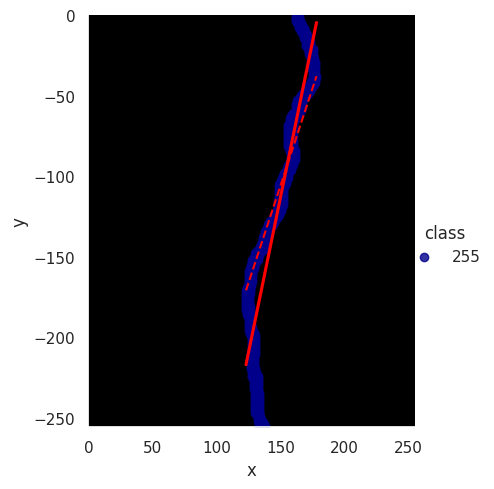

In [ ]:
from scipy.stats import linregress
import math
import pandas as pd

def plot1(array):
    n, m = array.shape
    a = []
    b = []
    c = []
    d = []
    for i in range(n):
        for j in range(m):
            if array[i][j] == 255:
                a.append(i)
                b.append(j)
            elif array[i][j] == 2:
                c.append(i)
                d.append(j)

    slope, intercept, r_value, p_value, std_err = linregress(a, b)
    print('s1', slope * 180 / math.pi)

    # slope, intercept, r_value, p_value, std_err = linregress(c,d)
    # print('s1',slope * 180 / math.pi)

    a = []
    b = []
    c = []
    for i in range(n):
        for j in range(m):
            if array[i][j]:
                a.append(-i)
                b.append(j)
                c.append(array[i][j])

    df = pd.DataFrame()
    df['x'] = b
    df['y'] = a
    df['class'] = c

    # Calculate the endpoints of the crack
    x_start = min(df['x'])
    x_end = max(df['x'])
    y_start = df[df['x'] == x_start]['y'].values[0]
    y_end = df[df['x'] == x_end]['y'].values[0]

    # Fit a line between the endpoints
    line_points = pd.DataFrame({'x': [x_start, x_end], 'y': [y_start, y_end]})
    slope, intercept, r_value, p_value, std_err = linregress(line_points['x'], line_points['y'])
    print('Line slope:', slope)

    return df, line_points

# Load the segmented image
segmented_img = cv2.imread('/content/output_median_closing.png', cv2.IMREAD_GRAYSCALE)

# Perform necessary processing to get the crack data and line points
df, line_points = plot1(segmented_img)

# Customize the plot as needed
custom_params = {'axes.facecolor': 'black', 'axes.grid': False}
sb.set_theme(rc=custom_params)

colors = ["#00008B", "w"]
sb.set_palette(sb.color_palette(colors))

# Plot the crack and the fitted red line
ax = sb.lmplot(x="x",
               y="y",
               hue='class',
               ci=None,
               data=df,
               line_kws={"color": "red"})

# Plot the red line between the endpoints
plt.plot(line_points['x'], line_points['y'], color='red', linestyle='--')

ax.figure.set_size_inches(5, 5)
ax.set(ylim=(-256, 0))
ax.set(xlim=(0, 255))

plt.show()

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
#output of semantic segmentation

img = cv2.imread('/content/output.png', cv2.IMREAD_GRAYSCALE)
Ai = np.count_nonzero(img == 255)
print(Ai)
print(img.shape,np.unique(img))
size = np.size(img)
skel = np.zeros(img.shape,np.uint8)
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
done = False
while not done:
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
    zeros = size - cv2.countNonZero(img)
    if zeros == size:
        done = True

sk  = cv2.cvtColor(skel,cv2.COLOR_GRAY2RGB)
#cv2_imshow(sk)
Li = np.count_nonzero(sk== 255)
Wi = Ai/Li
image_length_in = 18.4  # Example: Width of the image in centimeters
image_length_pixels = 256  # Width of the image in pixels

pixels_to_in = image_length_in / image_length_pixels
print(f'Length {pixels_to_in*Li}, Width{Wi}')
df = plot1(skel)

1020
(256, 256) [  0 255]
Length 76.76249999999999, Width0.9550561797752809
s1 -12.255212946755913
Line slope: 2.509433962264151


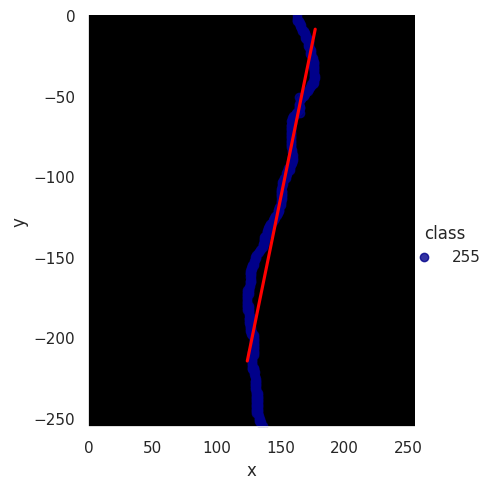

In [ ]:
import seaborn as sb
custom_params = {'axes.facecolor':'black','axes.grid' : False}
sb.set_theme(rc=custom_params)

colors = ["#00008B", "w"]
sb.set_palette(sb.color_palette(colors))
ax=sb.lmplot(x = "x",
            y = "y",
            hue='class',
            ci = None,
            data = df,
            line_kws={"color": "red"})

ax.figure.set_size_inches(5,5)
# print(ax.get_lines())
ax.set(ylim=(-256,0))
ax.set(xlim=(0,255))
plt.show()

Crack Length (in inches): 28.18700440641443
Image with Red Line saved at: /content/line_length.png


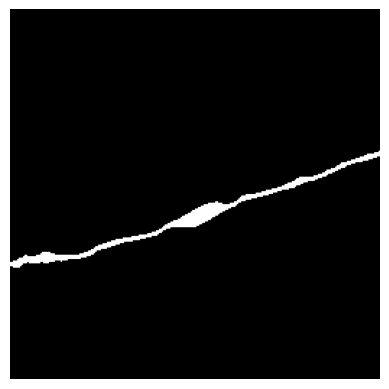

In [ ]:
import cv2
import numpy as np
from scipy.stats import linregress
import math
import matplotlib.pyplot as plt

def find_endpoints(segmented_img):
    # Find the coordinates of the crack points
    crack_points = np.where(segmented_img == 255)
    x = crack_points[1]
    y = -crack_points[0]  # Reverse the y-axis for plotting

    # Find the endpoints of the crack
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    return (x_min, y_min), (x_max, y_max)

def draw_line_on_crack(segmented_img_path):
    # Load the segmented image
    segmented_img = cv2.imread(segmented_img_path, cv2.IMREAD_GRAYSCALE)

    # Find the endpoints of the crack
    start_point, end_point = find_endpoints(segmented_img)

    # Draw a red line on the crack image between the endpoints
    line_color = (0, 0, 255)  # Red color
    line_thickness = 2
    crack_img_with_line = cv2.cvtColor(segmented_img, cv2.COLOR_GRAY2BGR)
    cv2.line(crack_img_with_line, start_point, end_point, line_color, line_thickness)

    # Calculate the length of the crack
    crack_length_pixels = np.sqrt((end_point[0] - start_point[0]) ** 2 + (end_point[1] - start_point[1]) ** 2)

    image_width_pixels = 256
    image_height_pixels = 256
    image_width_inches = 27
    image_height_inches = 27

    horizontal_ppi = image_width_inches/ image_width_pixels
    vertical_ppi = image_height_inches/ image_height_pixels

    pixels_per_inch = (horizontal_ppi + vertical_ppi)/2

    # Convert crack length from pixels to inches
    crack_length_inches = crack_length_pixels * pixels_per_inch

    # Save the image with the red line
    output_img_path = '/content/line_length.png'
    cv2.imwrite(output_img_path, crack_img_with_line)

    return crack_length_inches, output_img_path

def display_image_with_line(image_path, start_point, end_point):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Draw the red line on the image
    line_color = (0, 0, 255)  # Red color
    line_thickness = 2
    cv2.line(img, start_point, end_point, line_color, line_thickness)

    # Display the image with the red line
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example usage
segmented_img_path = '/content/output_median_closing.png'
crack_length, output_img_path = draw_line_on_crack(segmented_img_path)
print("Crack Length (in inches):", crack_length)
print("Image with Red Line saved at:", output_img_path)

# Display the image with the red line
start_point, end_point = find_endpoints(cv2.imread(segmented_img_path, cv2.IMREAD_GRAYSCALE))
display_image_with_line(output_img_path, start_point, end_point)


Distance between the circles (in inches): 28.218754866590114


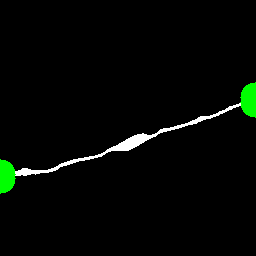

In [ ]:
from scipy.spatial.distance import euclidean

img = cv2.imread('/content/output_median_closing.png')
img2 = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
skeleton = cv2.ximgproc.thinning(th, None, 1)

k1 = np.array(([ 0, 0,  0],
               [-1, 1, -1],
               [-1,-1, -1]), dtype="int")

k2 = np.array(([0, -1, -1],
               [0,  1, -1],
               [0, -1, -1]), dtype="int")

k3 = np.array(([-1, -1, 0],
               [-1,  1, 0],
               [-1, -1, 0]), dtype="int")

k4 = np.array(([-1, -1, -1],
               [-1,  1, -1],
               [ 0,  0,  0]), dtype="int")

o1 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k1)
o2 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k2)
o3 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k3)
o4 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k4)
out1 = o1 + o2 + o3 + o4

k5 = np.array(([-1, -1, -1],
               [-1,  1, -1],
               [ 0, -1, -1]), dtype="int")

k6 = np.array(([-1, -1, -1],
               [-1,  1, -1],
               [-1, -1,  0]), dtype="int")

k7 = np.array(([-1, -1,  0],
               [-1,  1, -1],
               [-1, -1, -1]), dtype="int")

k8 = np.array(([ 0, -1, -1],
               [-1,  1, -1],
               [-1, -1, -1]), dtype="int")

o5 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k5)
o6 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k6)
o7 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k7)
o8 = cv2.morphologyEx(skeleton, cv2.MORPH_HITMISS, k8)
out2 = o5 + o6 + o7 + o8


out = cv2.add(out1, out2)
pts = np.argwhere(out == 255)
endpoints = []
for pt in pts:
    img2 = cv2.circle(img2, (pt[1], pt[0]), 15, (0, 255, 0), -1)
    endpoints.append((pt[1], pt[0]))


# print(endpoints)
# Calculate the Euclidean distance between the endpoints
distance_pixels = euclidean(endpoints[0], endpoints[3])

image_width_pixels = 256
image_height_pixels = 256
image_width_inches = 27
image_height_inches = 27

horizontal_ppi = image_width_inches/image_width_pixels
vertical_ppi = image_height_inches/image_height_pixels

pixels_per_inch = (horizontal_ppi + vertical_ppi) / 2

# Convert distance from pixels to inches
distance_inches = distance_pixels*pixels_per_inch

print("Distance between the circles (in inches):", distance_inches)

# Display the image with circles
cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

Experiment

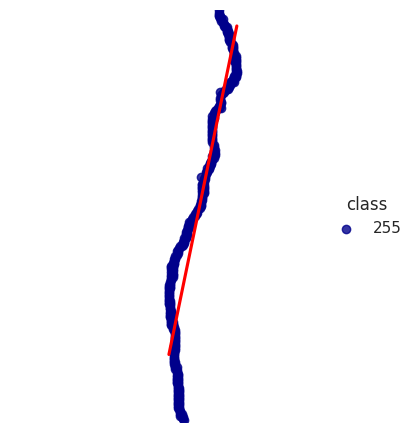

In [ ]:
import seaborn as sb
custom_params = {'axes.facecolor':'black','axes.grid' : False}
sb.set_theme(rc=custom_params)

colors = ["#00008B", "w"]
sb.set_palette(sb.color_palette(colors))
ax=sb.lmplot(x = "x",
            y = "y",
            hue='class',
            ci = None,
            data = df,
            line_kws={"color": "red"})


ax.figure.set_size_inches(5,5)
# print(ax.get_lines())
ax.set(ylim=(-256,0))
ax.set(xlim=(0,255))
plt.axis('off')
plt.savefig('line_img.png')
plt.show()

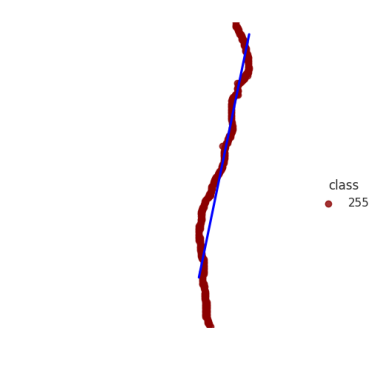

In [ ]:
img = cv2.imread('/content/line_img.png')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
unique_pixels =np.unique(img)
print(unique_pixels)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [ ]:
img[0,0]

array([255, 255, 255], dtype=uint8)

Line Length (in): 15.149175652067582


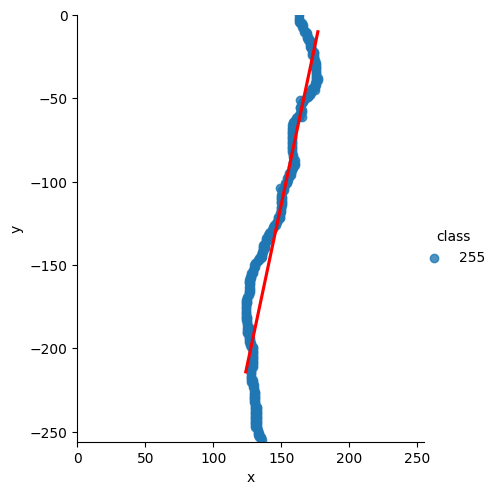

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

# Define the conversion factor from pixels to centimeters
image_length_in = 18.4  # Example: Width of the image in centimeters
image_length_pixels = 256  # Width of the image in pixels

pixels_to_in = image_length_in / image_length_pixels
 # Adjust this value based on your image or plotting device

# Rest of your code...

ax = sb.lmplot(x="x",
               y="y",
               hue='class',
               ci=None,
               data=df,
               line_kws={"color": "red"})

ax.figure.set_size_inches(5, 5)
ax.set(ylim=(-256, 0))
ax.set(xlim=(0, 255))

# Retrieve line data
lines = ax.ax.lines[0]
x_data = lines.get_xdata()
y_data = lines.get_ydata()

# Calculate line length in pixels
line_length_pixels = np.sum(np.sqrt(np.diff(x_data)**2 + np.diff(y_data)**2))

# Convert line length to centimeters
line_length_in = line_length_pixels * pixels_to_in

# Display line length in centimeters
print("Line Length (in):", line_length_in)

plt.show()


exp ends

don't run the next cell, run the next to next cell

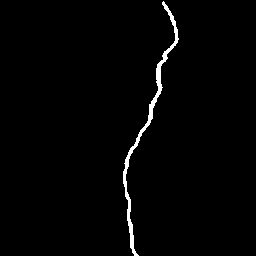

0 0


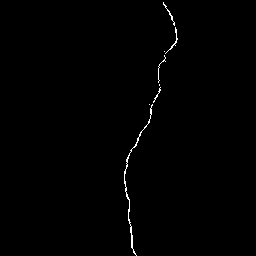

ZeroDivisionError: ignored

In [ ]:
from google.colab.patches import cv2_imshow
images=['/content/output.png']

for i, x in enumerate(images):
  org_img = cv2.imread(x)
  img = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
  l,w,h = org_img.shape
  c=0
  d=0
  for i in range(l):
    for j in range(w):
      if img[i][j]==1:
        org_img[i][j][0] = 150
        org_img[i][j][1] = 0
        org_img[i][j][2] = 0
        d+=1
      elif img[i][j]==2:
        org_img[i][j][0] = 255
        org_img[i][j][1] = 255
        org_img[i][j][2] = 255
        c+=1
  #cv2.imwrite('Output3.png',org_img)
  cv2_imshow(org_img)
  print(c,d)
  size = np.size(img)
  skel = np.zeros(img.shape,np.uint8)
  element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
  done = False
  while not done:
      eroded = cv2.erode(img,element)
      temp = cv2.dilate(eroded,element)
      temp = cv2.subtract(img,temp)
      skel = cv2.bitwise_or(skel,temp)
      img = eroded.copy()
      zeros = size - cv2.countNonZero(img)
      if zeros == size:
          done = True

  sk  = cv2.cvtColor(skel,cv2.COLOR_GRAY2RGB)
  e=0
  f=0

  for i in range(l):
    for j in range(w):
      if skel[i][j]==1:
        sk[i][j][0] = 150
        sk[i][j][1] = 0
        sk[i][j][2] = 0
        f+=1
      elif skel[i][j]==2:
        sk[i][j][0] = 255
        sk[i][j][1] = 255
        sk[i][j][2] = 255
        e+=1

  cv2_imshow(sk)
  print(e,f,c/e,d/f)
  df = plot1(skel)
  break

df

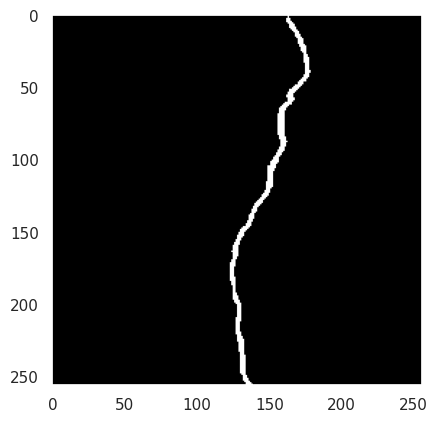

0 0


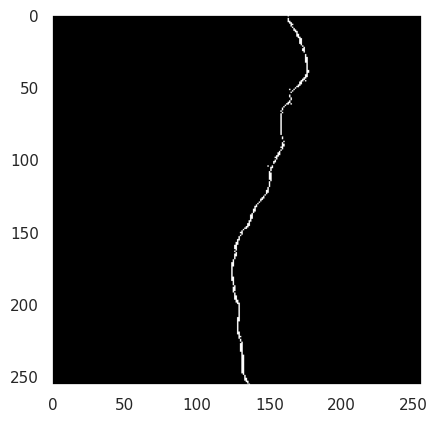

0 0 Cannot divide by zero
s1 -12.401359085359298


,x,y,class
0,163,0,255
1,163,-2,255
2,163,-3,255
3,163,-4,255
4,164,-4,255
...,...,...,...
361,134,-252,255
362,134,-253,255
363,135,-253,255
364,135,-254,255


In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

images = ['/content/output.png']

for i, x in enumerate(images):
    org_img = cv2.imread(x)
    img = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    l, w, h = org_img.shape
    c = 0
    d = 0
    for i in range(l):
        for j in range(w):
            if img[i][j] == 1:
                org_img[i][j][0] = 150
                org_img[i][j][1] = 0
                org_img[i][j][2] = 0
                d += 1
            elif img[i][j] == 2:
                org_img[i][j][0] = 255
                org_img[i][j][1] = 255
                org_img[i][j][2] = 255
                c += 1
    # cv2.imwrite('Output3.png', org_img)
    plt.imshow(cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB))
    plt.show()
    print(c, d)
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False
    while not done:
        eroded = cv2.erode(img, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        zeros = size - cv2.countNonZero(img)
        if zeros == size:
            done = True

    sk = cv2.cvtColor(skel, cv2.COLOR_GRAY2RGB)
    e = 0
    f = 0

    for i in range(l):
        for j in range(w):
            if skel[i][j] == 1:
                sk[i][j][0] = 150
                sk[i][j][1] = 0
                sk[i][j][2] = 0
                f += 1
            elif skel[i][j] == 2:
                sk[i][j][0] = 255
                sk[i][j][1] = 255
                sk[i][j][2] = 255
                e += 1

    plt.imshow(cv2.cvtColor(sk, cv2.COLOR_BGR2RGB))
    plt.show()
    if e != 0:
        print(e, f, c / e, d / f)
    else:
        print(e, f, 'Cannot divide by zero')
    df = plot1(skel)
    break

df


In [ ]:
df=pd.read_csv('reg.csv')
import seaborn as sb

custom_params = {'axes.facecolor':'black',}
sb.set_theme(rc=custom_params)
sb.set_style({'axes.grid' : False})
colors = ["#00008B", "w"]
sb.set_palette(sb.color_palette(colors))
ax=sb.lmplot(x = "x",
            y = "y",
            hue='class',
            ci = None,
            data = df,
            line_kws={"color": "red"})

ax.figure.set_size_inches(5,5)
ax.set(ylim=(-227,0))
ax.set(xlim=(0,227))

FileNotFoundError: ignored

1. erode
2. flip(negate)(-img)
3. intersection with original image(img 1(before negating) AND img 2(after negating))
4. count number of 1 pixels in the resulting image. this will give number pixels of edges. divide this by two to get the length of crack.
